# 针对特定任务与模型训练的数据处理
***数据处理流程供参考，具体处理代码实现请针对具体数据做相应调整***

根据任务与模型加载需求用相应数据处理方法

## 导入必要包

In [28]:
import numpy as np
import h5py
from tqdm import tqdm
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import cv2  # 用于 bicubic 图像缩放的 OpenCV 库
import webdataset as wds
import torch
from torch.utils.data import DataLoader
from datetime import datetime, timedelta
import shutil
import os, glob, io, tarfile, json, math
from typing import Dict, Optional

## 检查数据

In [29]:
patch = 123
data_path = 'demo.h5' # 请替换为你的H5文件路径
with h5py.File(data_path, 'r') as hf:
    print(hf.keys())
    print(hf.visititems(lambda name, obj: print(f"{name}: {obj.shape}, {obj.dtype}")))
    uovo_data = hf['uovo_data'][patch, ...]
    mask_data = hf['mask'][patch % 147, ...]
    lon_data = hf['lon'][patch % 147, ...]
    lat_data = hf['lat'][patch % 147, ...]
    print(type(uovo_data), type(mask_data), type(lon_data), type(lat_data))
    print(f"uovo_data shape: {uovo_data.shape}, dtype: {uovo_data.dtype}")
    print(f"mask_data shape: {mask_data.shape}, dtype: {mask_data.dtype}")
    print(f"lon_data shape: {lon_data.shape}, dtype: {lon_data.dtype}")
    print(f"lat_data shape: {lat_data.shape}, dtype: {lat_data.dtype}")

<KeysViewHDF5 ['lat', 'lon', 'mask', 'uovo_data']>
lat: (294, 448, 448), float32
lon: (294, 448, 448), float32
mask: (294, 448, 448), bool
uovo_data: (294, 2, 448, 448), float32
None
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
uovo_data shape: (2, 448, 448), dtype: float32
mask_data shape: (448, 448), dtype: bool
lon_data shape: (448, 448), dtype: float32
lat_data shape: (448, 448), dtype: float32


## 可视化一个例子

(448, 448) (448, 448)


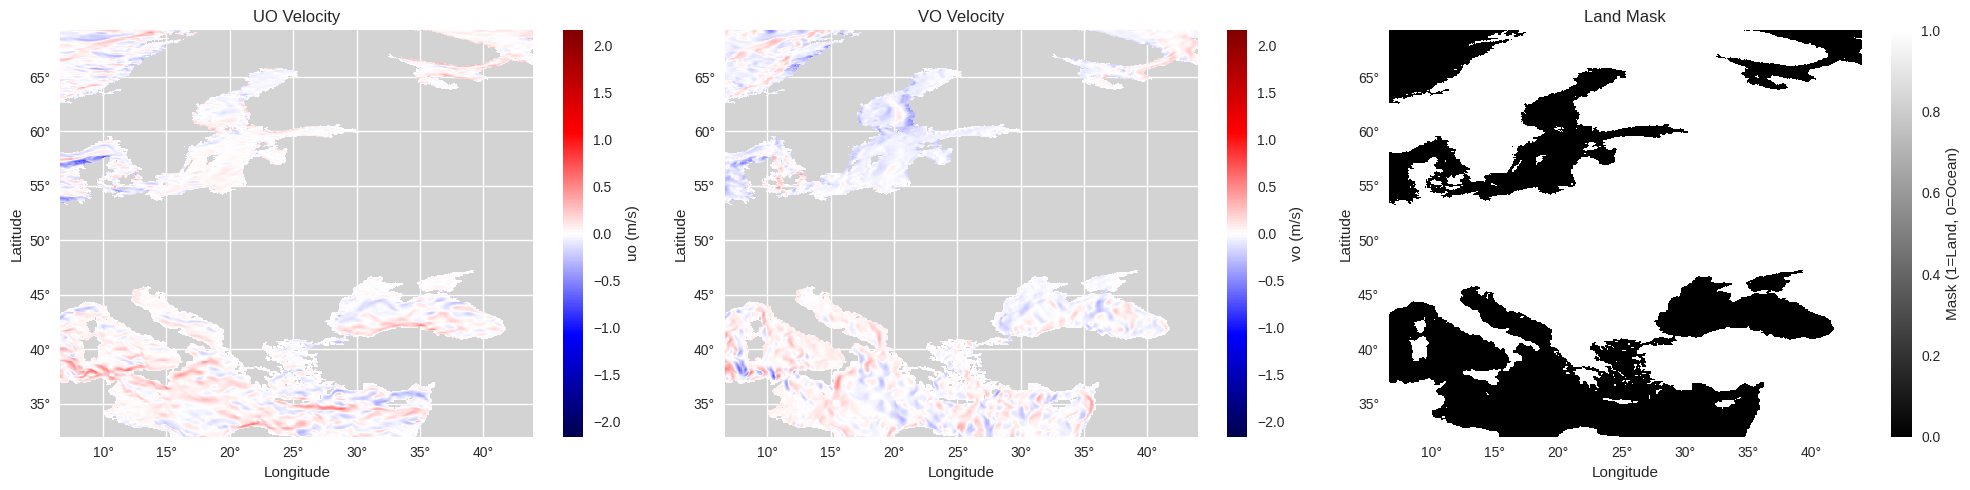

In [30]:
# 经纬度格式化函数
def fmt(x, pos):
    val = ((x + 180) % 360) - 180
    return f"{val:.0f}°"

# 画图
import matplotlib.pyplot as plt
uo_sample = uovo_data[0, :, :]  # 取第一个数据块的第一个通道
vo_sample = uovo_data[1, :, :]  # 取第一个数据块的第二个通道
mask_sample = mask_data
lon_sample = lon_data
lat_sample = lat_data
lon_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(lon_sample)))  # unwrap经度
lat_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(lat_sample)))
print(lon_unwrapped.shape, lat_unwrapped.shape)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, uo_sample, shading='auto', cmap='seismic', vmax=2.1637623198330402, vmin=-2.1637623198330402) # pcolormesh遇到掩码数组会自动处理掩码
plt.colorbar(label='uo (m/s)')
plt.title('UO Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# 用fmt格式化经纬度刻度
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色

plt.subplot(1, 3, 2)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, vo_sample, shading='auto', cmap='seismic', vmax=2.1637623198330402, vmin=-2.1637623198330402) # 设置颜色范围
plt.colorbar(label='vo (m/s)')
plt.title('VO Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色

plt.subplot(1, 3, 3)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, mask_sample, shading='auto', cmap='gray') # pcolormesh遇到掩码数组会自动处理掩码
plt.colorbar(label='Mask (1=Land, 0=Ocean)')
plt.title('Land Mask')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色
plt.tight_layout()
plt.show()

## 分析需求并处理数据
***按具体任务和模型需求设计数据保存方式，分为`train/val/test`***
- 对于数据量较小的数据集(如占用空间小于内存20%)，直接用np.load加载数据效率最高且随机性良好
- 对于数据量较大的数据集(如占用空间大于内存50%)，可能会因为内存空间不足或全部载入内存后系统卡顿而不适合一次性全部载入内存，此时需要用文件索引访问数据文件
- 这里推荐使用webdataset加载数据到模型，webdataset牺牲部分随机性，支持安全地多进程多线程同时读取文件
- 可结合[webdataset官方文档](https://webdataset.github.io/webdataset/webdataset/)，博客与AI工具学习webdataset的使用

此demo原数据占用空间约为内存35%，设计为用webdataset加载数据

webdataset要求数据先切好片，以.tar形式存储，这里把数据打包为包含高分辨率、低分辨率、经纬度、陆地掩码和日期的tar文件

In [31]:
# --- 数据打包函数 ---
def create_shards(
    h5_path: str,
    output_dir: str,
    start_date_str: str,
    downscale_factor: int = 4,
    days_per_shard: int = 10,
    patches_per_day: int = 147,
    auto_split: bool = False,
    train_ratio: float = 0.7,
    val_ratio: float = 0.2
):
    """
    从 HDF5 文件创建 WebDataset TAR shards。
    每个 shard 的文件名为该 shard 覆盖的第一天日期，例如 2023-11-01.tar
    
    Args:
        auto_split: 是否自动按时间顺序划分到 train/val/test 子目录
        train_ratio: 训练集比例（默认 0.7）
        val_ratio: 验证集比例（默认 0.2，剩余为测试集）
    """

    os.makedirs(output_dir, exist_ok=True)
    print(f"开始在目录 {output_dir} 中创建 TAR shards...")
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    samples_per_shard = patches_per_day * days_per_shard  # 每个 shard 包含的样本数

    with h5py.File(h5_path, 'r') as hf:
        n_total_patches = hf['uovo_data'].shape[0]
        lon_static = hf['lon'][:]
        lat_static = hf['lat'][:]
        mask_static = hf['mask'][:]
        uovo_data = hf['uovo_data']

        # 计算总天数和总分片数
        total_days = (n_total_patches + patches_per_day - 1) // patches_per_day
        total_shards = (total_days + days_per_shard - 1) // days_per_shard
        
        # 如果启用自动划分，创建子目录并计算划分点
        if auto_split:
            for split in ["train", "val", "test"]:
                os.makedirs(os.path.join(output_dir, split), exist_ok=True)
            
            train_end = int(total_shards * train_ratio)
            val_end = int(total_shards * (train_ratio + val_ratio))
            
            print(f"自动划分设置:")
            print(f"  总分片数: {total_shards}")
            print(f"  train: 分片 0-{train_end-1} ({train_end} 个)")
            print(f"  val:   分片 {train_end}-{val_end-1} ({val_end-train_end} 个)")
            print(f"  test:  分片 {val_end}-{total_shards-1} ({total_shards-val_end} 个)")

        shard_idx = 0
        # 按天分组，每 days_per_shard 天写一个 tar，文件名取该组第一天日期
        for day_start in range(0, total_days, days_per_shard):
            shard_first_date = start_date + timedelta(days=day_start)
            shard_fname = shard_first_date.strftime('%Y-%m-%d') + ".tar"
            
            # 根据是否自动划分确定输出路径
            if auto_split:
                if shard_idx < train_end:
                    split = "train"
                elif shard_idx < val_end:
                    split = "val"
                else:
                    split = "test"
                shard_path = os.path.join(output_dir, split, shard_fname)
                split_info = f" -> {split}"
            else:
                shard_path = os.path.join(output_dir, shard_fname)
                split_info = ""

            shard_start_idx = day_start * patches_per_day
            shard_end_idx = min(shard_start_idx + samples_per_shard, n_total_patches)

            print(f"写入分片 {shard_idx+1}/{total_shards}: {shard_fname}{split_info}")

            with wds.TarWriter(shard_path) as sink:
                for i in range(shard_start_idx, shard_end_idx):
                    # 1) 样本所属日期（逐样本）
                    days_offset = i // patches_per_day
                    current_date = start_date + timedelta(days=days_offset)
                    date_str = current_date.strftime('%Y-%m-%d')

                    # 2) GT
                    gt_uv_raw = uovo_data[i]
                    if np.ma.isMaskedArray(gt_uv_raw):
                        gt_uv = gt_uv_raw.filled(np.nan).astype(np.float32)
                    else:
                        gt_uv = gt_uv_raw.astype(np.float32)

                    # 3) 静态数据
                    static_idx = i % patches_per_day
                    mask = mask_static[static_idx].astype(np.bool_)
                    lon = lon_static[static_idx].astype(np.float32)
                    lat = lat_static[static_idx].astype(np.float32)

                    # 4) 生成 LQ（保持与 GT 一致的 NaN 掩码）
                    h, w = gt_uv.shape[1], gt_uv.shape[2]
                    lq_h, lq_w = h // downscale_factor, w // downscale_factor
                    uv_hw2 = np.transpose(gt_uv, (1, 2, 0))                   # (H,W,2)

                    # 将 NaN 临时替换为 0 进行插值
                    val_hw2 = np.nan_to_num(uv_hw2, nan=0.0).astype(np.float32)

                    down_hw2 = cv2.resize(val_hw2, (lq_w, lq_h), interpolation=cv2.INTER_CUBIC) # bicubic 下采样
                    up_hw2 = cv2.resize(down_hw2, (w, h), interpolation=cv2.INTER_CUBIC)       # (H,W,2)，bicubic 上采样
                    lq_uv = np.transpose(up_hw2, (2, 0, 1)).astype(np.float32) # (2,H,W)

                    # 强制保持与 GT 完全一致的 NaN 位置
                    lq_uv[np.isnan(gt_uv)] = np.nan
                    
                    # 5) 写入样本
                    sample = {
                        "__key__": f"{i:09d}",
                        "gt.npy": gt_uv,
                        "lq.npy": lq_uv,
                        "lon.npy": lon,
                        "lat.npy": lat,
                        "mask.npy": mask,
                        "date.txt": date_str,
                    }
                    sink.write(sample)

                    if (i + 1) % 1000 == 0:
                        print(f"  已处理并写入 {i+1}/{n_total_patches} 个样本...")

            print(f"完成写入: {shard_path}，样本范围 [{shard_start_idx}, {shard_end_idx-1}] 共 {shard_end_idx - shard_start_idx} 个")
            shard_idx += 1

# ---------------------创建tar shards------------------------
demo_tar_dir = '' # 请填入数据保存的文件夹路径
shards_dir = os.path.join(demo_tar_dir, "shards")

patches_per_day = 10 # 生成h5文件时定义的一天的数据的patch数，便于记录日期信息，此处为了演示设置为小一点
days_per_shard = 1 # 每个 TAR shard 包含的天数
downscale_factor = 4 # 生成的低分辨率图的下采样倍数
train_ratio = 0.7 # 训练集比例
val_ratio = 0.2 # 验证集比例（测试集 = 1 - train_ratio - val_ratio）
start_date = '1997-01-01' # 数据集开始日期，便于记录日期信息
h5_path = 'demo.h5' 

# --- 创建 TAR Shards ---
print("\n 创建 TAR shards...")
create_shards(
    h5_path, 
    shards_dir, 
    start_date_str=start_date, 
    patches_per_day=patches_per_day, 
    downscale_factor=downscale_factor, 
    days_per_shard=days_per_shard,
    auto_split=True,          # 启用自动划分
    train_ratio=train_ratio,          # 训练集比例
    val_ratio=val_ratio             # 验证集比例（测试集 = 1 - 0.7 - 0.2 = 0.1）
)


 创建 TAR shards...
开始在目录 shards 中创建 TAR shards...


自动划分设置:
  总分片数: 30
  train: 分片 0-20 (21 个)
  val:   分片 21-25 (5 个)
  test:  分片 26-29 (4 个)
写入分片 1/30: 1997-01-01.tar -> train
完成写入: shards/train/1997-01-01.tar，样本范围 [0, 9] 共 10 个
写入分片 2/30: 1997-01-02.tar -> train
完成写入: shards/train/1997-01-02.tar，样本范围 [10, 19] 共 10 个
写入分片 3/30: 1997-01-03.tar -> train
完成写入: shards/train/1997-01-03.tar，样本范围 [20, 29] 共 10 个
写入分片 4/30: 1997-01-04.tar -> train
完成写入: shards/train/1997-01-04.tar，样本范围 [30, 39] 共 10 个
写入分片 5/30: 1997-01-05.tar -> train
完成写入: shards/train/1997-01-05.tar，样本范围 [40, 49] 共 10 个
写入分片 6/30: 1997-01-06.tar -> train
完成写入: shards/train/1997-01-06.tar，样本范围 [50, 59] 共 10 个
写入分片 7/30: 1997-01-07.tar -> train
完成写入: shards/train/1997-01-07.tar，样本范围 [60, 69] 共 10 个
写入分片 8/30: 1997-01-08.tar -> train
完成写入: shards/train/1997-01-08.tar，样本范围 [70, 79] 共 10 个
写入分片 9/30: 1997-01-09.tar -> train
完成写入: shards/train/1997-01-09.tar，样本范围 [80, 89] 共 10 个
写入分片 10/30: 1997-01-10.tar -> train
完成写入: shards/train/1997-01-10.tar，样本范围 [90, 99] 共 10 个
写入分片 11/30

## 检查处理好的数据
***可构建简单的dataset与dataloader模拟模型训练时加载数据***

若不清楚dataset和dataloader是什么可参考[pytorch tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

此处用webdataset与webloader加载

In [32]:
# --- WebDataset 与 DataLoader 构建 ---
class DataPreprocessorZScore:
    """
    一个可调用的类，用于在 WebDataset 流水线中对每个样本进行 Z-score 归一化预处理。
    """
    def __init__(self, stats: dict):
        """
        初始化预处理器。

        Args:
            stats (dict): 一个包含均值和标准差的字典。
                          例如: {'uv_mean': 0.0, 'uv_std': 1.0, ...}
        """
        # 将统计数据转换为 tensor，方便计算
        self.uv_mean = torch.tensor(stats['uv_mean'])
        self.uv_std = torch.tensor(stats['uv_std'])
    
    def normalize(self, data: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        """执行 Z-score 归一化 (standardization)"""
        # 防止除以零
        std[std == 0] = 1.0
        return (data - mean) / std

    def __call__(self, sample: dict) -> dict:
        """
        处理从 webdataset.decode 后的样本字典。
        
        Args:
            sample (dict): 包含 numpy 数组和文本的字典。
        
        Returns:
            dict: 包含已归一化并调整好形状的 PyTorch tensors 的字典。
        """
        gt = torch.from_numpy(sample['gt.npy'])
        lq = torch.from_numpy(sample['lq.npy'])
        lon = torch.from_numpy(sample['lon.npy'])
        lat = torch.from_numpy(sample['lat.npy'])
        mask = torch.from_numpy(sample['mask.npy'])
        date = sample['date.txt']

        # Z-score 归一化
        gt_norm = self.normalize(gt, self.uv_mean, self.uv_std)
        lq_norm = self.normalize(lq, self.uv_mean, self.uv_std)
        
        # 将nan值替换为0
        gt_norm[torch.isnan(gt_norm)] = 0.0
        lq_norm[torch.isnan(lq_norm)] = 0.0
        # 为 lon, lat, mask 添加通道维度 (H, W) -> (1, H, W)
        return {
            "gt": gt_norm,
            "lq": lq_norm,
            "lon": lon.unsqueeze(0),
            "lat": lat.unsqueeze(0),
            "mask": mask.to(torch.float32).unsqueeze(0),
            "date": date
        }

def create_dataloader(tar_pattern: str, stats: dict, batch_size: int, num_workers: int = 0, phase: str = "train") -> DataLoader:
    """
    创建并返回一个用于训练/验证/测试的 DataLoader。

    Args:
        tar_pattern (str): 对应 phase 的 TAR shards 的 glob 模式。
        stats (dict): 包含均值和标准差的字典。
        batch_size (int): 每个 batch 的大小。
        num_workers (int): 用于数据加载的子进程数量。
        phase (str): 'train' | 'val' | 'test'
    """
    if phase not in {"train", "val", "test"}:
        raise ValueError(f"phase 必须是 'train' | 'val' | 'test'，收到: {phase}")

    print(f"正在创建 {phase} DataLoader...")

    tar_files = sorted(glob.glob(tar_pattern))
    if not tar_files:
        raise ValueError(f"[{phase}] 没有找到与模式 '{tar_pattern}' 匹配的文件")
    print(f"[{phase}] 找到 {len(tar_files)} 个匹配的 TAR 文件")

    preprocessor = DataPreprocessorZScore(stats)

    if phase == "train":
        # 训练：resampled 无限流 + 打乱 + 丢弃不满 batch
        dataset = (
            wds.WebDataset(tar_files, resampled=True)
            .shuffle(1000)
            .decode()
            .map(preprocessor)
            .to_tuple("gt", "lq", "lon", "lat", "mask", "date")
            .batched(batch_size, partial=False)
        )
    else:
        # 验证/测试：确定性顺序，不打乱，保留不满 batch
        dataset = (
            wds.WebDataset(tar_files)
            .decode()
            .map(preprocessor)
            .to_tuple("gt", "lq", "lon", "lat", "mask", "date")
            .batched(batch_size, partial=True)
        )

    loader = wds.WebLoader(dataset, batch_size=None, num_workers=num_workers, pin_memory=True)

    def dict_packer(batch):
        keys = ["gt", "lq", "lon", "lat", "mask", "date"]
        return {key: val for key, val in zip(keys, batch)}

    return loader.map(dict_packer)

# ------------------- 创建 DataLoader ------------------
# 提供均值标准差用于归一化
user_provided_stats = { # 请改为h5文件的数据的u和v的均值和方差
    'uv_mean': 0,
    'uv_std': 1,
}

print("\n 创建 DataLoader...")
batch_size = 4
train_tar_pattern = os.path.join(shards_dir, "train", "*.tar")
val_tar_pattern = os.path.join(shards_dir, "val", "*.tar")
test_tar_pattern = os.path.join(shards_dir, "test", "*.tar")
train_loader = create_dataloader(train_tar_pattern, stats=user_provided_stats, batch_size=batch_size, num_workers=32, phase="train")
val_loader = create_dataloader(val_tar_pattern, stats=user_provided_stats, batch_size=batch_size, num_workers=32, phase="val")
test_loader = create_dataloader(test_tar_pattern, stats=user_provided_stats, batch_size=batch_size, num_workers=32, phase="test")

# --- 提取并检查一个 Batch ---
print("\n 获取并检查一个批次的数据...")
first_batch = next(iter(train_loader))

print("\n成功获取一个批次！检查其内容:")
print("---------------------------------------------")
print(f"批次的键: {list(first_batch.keys())}")
print("---------------------------------------------")
for key, value in first_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"键: '{key}'")
        print(f"  - 类型: {value.dtype}")
        print(f"  - 形状: {value.shape}")
    else:
        print(f"键: '{key}'")
        print(f"  - 类型: {type(value)}")
        print(f"  - 长度: {len(value)}")
        print(f"  - 示例日期: {value[0]}")


 创建 DataLoader...
正在创建 train DataLoader...
[train] 找到 21 个匹配的 TAR 文件
正在创建 val DataLoader...
[val] 找到 5 个匹配的 TAR 文件
正在创建 test DataLoader...
[test] 找到 4 个匹配的 TAR 文件

 获取并检查一个批次的数据...



成功获取一个批次！检查其内容:
---------------------------------------------
批次的键: ['gt', 'lq', 'lon', 'lat', 'mask', 'date']
---------------------------------------------
键: 'gt'
  - 类型: torch.float32
  - 形状: torch.Size([4, 2, 448, 448])
键: 'lq'
  - 类型: torch.float32
  - 形状: torch.Size([4, 2, 448, 448])
键: 'lon'
  - 类型: torch.float32
  - 形状: torch.Size([4, 1, 448, 448])
键: 'lat'
  - 类型: torch.float32
  - 形状: torch.Size([4, 1, 448, 448])
键: 'mask'
  - 类型: torch.float32
  - 形状: torch.Size([4, 1, 448, 448])
键: 'date'
  - 类型: <class 'list'>
  - 长度: 4
  - 示例日期: 1997-01-14


## 可视化一个dataloader加载的数据例子
确保dataset，dataloader加载好的数据符合预期设计

(448, 448) (448, 448)


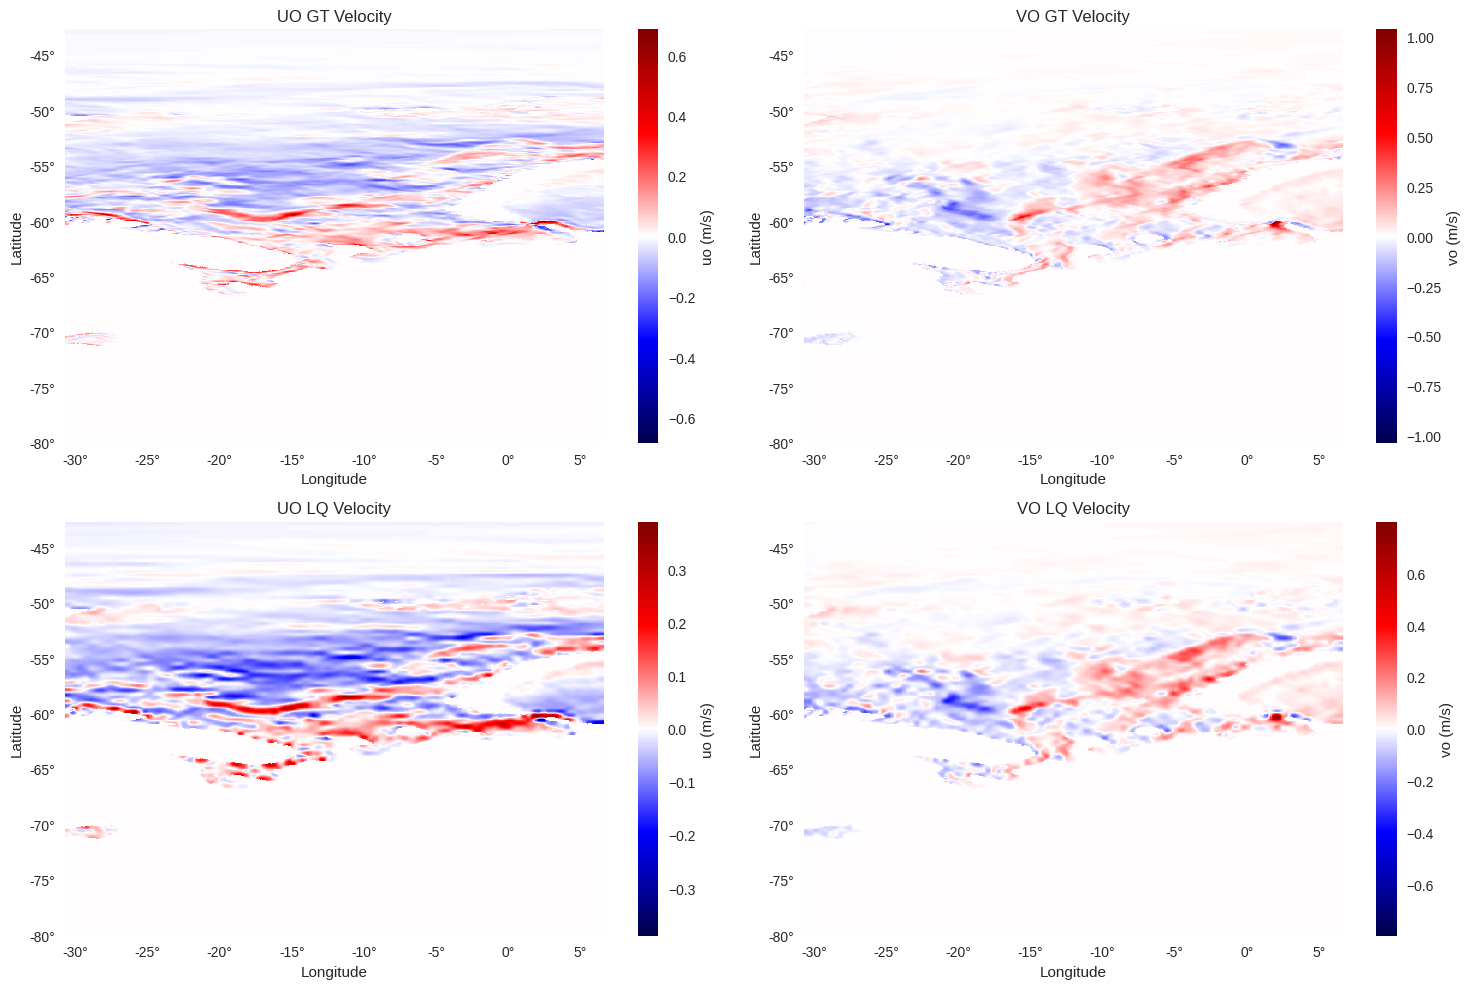

In [33]:
fig_save_path = 'demo_dataloader.png' # 填写图片保存路径
# 经纬度格式化函数
def fmt(x, pos):
    val = ((x + 180) % 360) - 180
    return f"{val:.0f}°"

# 取batch第一个样本画图
uo_gt = first_batch['gt'][0, 0, :, :]   
vo_gt = first_batch['gt'][0, 1, :, :]  
uo_lq = first_batch['lq'][0, 0, :, :]   
vo_lq = first_batch['lq'][0, 1, :, :]
lon_sample = first_batch['lon'][0 ,0, :, :]
lat_sample = first_batch['lat'][0 ,0, :, :]
lon_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(lon_sample)))  # unwrap经度
lat_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(lat_sample)))
print(lon_unwrapped.shape, lat_unwrapped.shape)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, uo_gt, shading='auto', cmap='seismic', vmax=np.nanmax(np.abs(uo_gt)), vmin=-np.nanmax(np.abs(uo_gt))) # pcolormesh遇到掩码数组会自动处理掩码
plt.colorbar(label='uo (m/s)')
plt.title('UO GT Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# 用fmt格式化经纬度刻度
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色

plt.subplot(2, 2, 2)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, vo_gt, shading='auto', cmap='seismic', vmax=np.nanmax(np.abs(vo_gt)), vmin=-np.nanmax(np.abs(vo_gt))) # 设置颜色范围
plt.colorbar(label='vo (m/s)')
plt.title('VO GT Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色

plt.subplot(2, 2, 3)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, uo_lq, shading='auto', cmap='seismic', vmax=np.nanmax(np.abs(uo_lq)), vmin=-np.nanmax(np.abs(uo_lq))) # pcolormesh遇到掩码数组会自动处理掩码
plt.colorbar(label='uo (m/s)')
plt.title('UO LQ Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰

plt.subplot(2, 2, 4)
plt.pcolormesh(lon_unwrapped, lat_unwrapped, vo_lq, shading='auto', cmap='seismic', vmax=np.nanmax(np.abs(vo_lq)), vmin=-np.nanmax(np.abs(vo_lq))) # 设置颜色范围
plt.colorbar(label='vo (m/s)')
plt.title('VO LQ Velocity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fmt)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.gca().set_facecolor('lightgray')  # 设置背景颜色为浅灰色
plt.tight_layout()
plt.savefig(fig_save_path, dpi=300)
plt.show()

- 模型训练的张量中不能有nan，dataset中把陆地部分的nan值换为了0，图中大片的白色即为陆地
- 数据输入模型前需要归一化，图中lq是归一化后的。colorbar值域和gt不同

## 检查训练验证测试集数据分布是否相差不大
***分别统计`train/val/test`的统计信息，画分布图***

In [34]:
# ---------- 统计量计算（忽略 NaN） ----------
def online_stats_update(sum_, sumsq_, count_, x):
    """
    累加一批数据的和、平方和与数量，忽略非有限值（NaN/Inf）。
    返回更新后的 (sum, sumsq, count)，用于在线计算均值与标准差。
    """
    mask = np.isfinite(x)
    v = x[mask]
    if v.size == 0:
        return sum_, sumsq_, count_
    sum_ += v.sum(dtype=np.float64)
    sumsq_ += (v.astype(np.float64) ** 2).sum(dtype=np.float64)
    count_ += v.size
    return sum_, sumsq_, count_

def compute_uv_stats_per_split(root_dir: str, phases=("train", "val", "test")) -> Dict:
    """
    分别统计 train/val/test 的 uv 均值和标准差（仅基于 GT；忽略 NaN/Inf）。
    返回:
    {
      "per_split": {
          "train": {"uv_mean": [...], "uv_std": [...], "count": [nu, nv]},
          "val":   {...},
          "test":  {...}
      }
    }
    """
    def iter_gt_from_tar(tar_path: str):
        with tarfile.open(tar_path, "r") as tar:
            members = tar.getnames()
            keys = sorted({n.split(".")[0] for n in members if n.endswith(".gt.npy")})
            for key in keys:
                with tar.extractfile(f"{key}.gt.npy") as f:
                    gt = np.load(io.BytesIO(f.read()), allow_pickle=False)  # [2,H,W]
                yield gt

    per_split = {}
    for phase in phases:
        s = np.zeros(2, dtype=np.float64)
        ss = np.zeros(2, dtype=np.float64)
        cnt = np.zeros(2, dtype=np.float64)

        tar_glob = os.path.join(root_dir, phase, "*.tar")
        tar_files = sorted(glob.glob(tar_glob))
        if not tar_files:
            raise RuntimeError(f"No shards matched: {tar_glob}")

        for tar_path in tar_files:
            for gt in iter_gt_from_tar(tar_path):
                for c in range(2):
                    s[c], ss[c], cnt[c] = online_stats_update(s[c], ss[c], cnt[c], gt[c])

        mean = s / np.maximum(cnt, 1.0)
        var = ss / np.maximum(cnt, 1.0) - np.square(mean)
        std = np.sqrt(np.maximum(var, 1e-12))

        per_split[phase] = {
            "uv_mean": mean.tolist(),
            "uv_std": std.tolist(),
            "count": cnt.astype(np.int64).tolist() # 格点数
        }

    return {
        "per_split": per_split,
    }

def plot_uv_hist_counts(root_dir: str, phases=("train", "val", "test"),
                        bins: int = 200, out_path: str = "uv_hist_counts.png",
                        stats: Optional[Dict] = None):
    """
    绘制 6 个子图直方图：上排 U、下排 V；每列一个 split（train/val/test）。
    - y 轴为 frequency（计数），不做截断
    - U/V 分别使用各自的统一全局范围与 bins（跨 split 一致）
    - 在每个子图上标注该 split 对应通道的 mean/std，并以竖线标出 mean 与 mean±std
    """
    # 第一次遍历：求全局范围
    u_min, u_max = np.inf, -np.inf
    v_min, v_max = np.inf, -np.inf

    for phase in phases:
        tar_glob = os.path.join(root_dir, phase, "*.tar")
        for tar_path in sorted(glob.glob(tar_glob)):
            with tarfile.open(tar_path, "r") as tar:
                names = tar.getnames()
                keys = sorted({n.split(".")[0] for n in names if n.endswith(".gt.npy")})
                for key in keys:
                    with tar.extractfile(f"{key}.gt.npy") as f:
                        gt = np.load(io.BytesIO(f.read()), allow_pickle=False)  # [2,H,W]
                    u = gt[0].ravel()
                    v = gt[1].ravel()
                    u = u[np.isfinite(u)]
                    v = v[np.isfinite(v)]
                    if u.size:
                        u_min = min(u_min, float(u.min()))
                        u_max = max(u_max, float(u.max()))
                    if v.size:
                        v_min = min(v_min, float(v.min()))
                        v_max = max(v_max, float(v.max()))

    if not np.isfinite(u_min):  # 数据为空保护
        u_min, u_max = -1.0, 1.0
    if not np.isfinite(v_min):
        v_min, v_max = -1.0, 1.0

    # 统一 bins（跨 split/通道保持一致）
    u_edges = np.linspace(u_min, u_max, bins + 1)
    v_edges = np.linspace(v_min, v_max, bins + 1)

    # 累计每个 split 的频数
    hist = {p: {"u": np.zeros(bins, dtype=np.int64),
                "v": np.zeros(bins, dtype=np.int64)} for p in phases}

    for phase in phases:
        tar_glob = os.path.join(root_dir, phase, "*.tar")
        for tar_path in sorted(glob.glob(tar_glob)):
            with tarfile.open(tar_path, "r") as tar:
                names = tar.getnames()
                keys = sorted({n.split(".")[0] for n in names if n.endswith(".gt.npy")})
                for key in keys:
                    with tar.extractfile(f"{key}.gt.npy") as f:
                        gt = np.load(io.BytesIO(f.read()), allow_pickle=False)  # [2,H,W]
                    u = gt[0].ravel()
                    v = gt[1].ravel()
                    u = u[np.isfinite(u)]
                    v = v[np.isfinite(v)]
                    if u.size:
                        h, _ = np.histogram(u, bins=u_edges)
                        hist[phase]["u"] += h
                    if v.size:
                        h, _ = np.histogram(v, bins=v_edges)
                        hist[phase]["v"] += h

    # 绘图：2 行 x len(phases) 列；柱状直方图，并标注均值/标准差
    plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
    ncols = len(phases)
    fig, axes = plt.subplots(2, ncols, figsize=(6 * ncols, 8), sharex=False, sharey=False)

    # 若只有一个 phase，axes 维度处理
    if ncols == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    colors = {"u": "#1f77b4", "v": "#ff7f0e"}
    u_widths = np.diff(u_edges)
    v_widths = np.diff(v_edges)

    def annotate(ax, mean_val: float, std_val: float, color: str):
        if mean_val is None or std_val is None:
            return
        # 竖线：mean 与 mean±std
        ax.axvline(mean_val, color="k", linestyle="--", linewidth=1)
        ax.axvline(mean_val - std_val, color="k", linestyle=":", linewidth=1)
        ax.axvline(mean_val + std_val, color="k", linestyle=":", linewidth=1)
        # 文本标注放在右上角
        ax.text(0.98, 0.95, f"mean={mean_val:.3f}\nstd={std_val:.3f}",
                transform=ax.transAxes, ha="right", va="top",
                fontsize=9, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    for i, p in enumerate(phases):
        # 从 stats 取均值/标准差（若提供）
        mu_u = sd_u = mu_v = sd_v = None
        if stats and isinstance(stats, dict):
            try:
                ps = stats["per_split"][p]
                mu_u, mu_v = float(ps["uv_mean"][0]), float(ps["uv_mean"][1])
                sd_u, sd_v = float(ps["uv_std"][0]), float(ps["uv_std"][1])
            except Exception:
                pass

        # U 子图（上排）
        ax_u = axes[0, i]
        ax_u.bar(u_edges[:-1], hist[p]["u"], width=u_widths, align="edge",
                 color=colors["u"], edgecolor="none", alpha=0.9)
        ax_u.set_title(f"{p} - U histogram (counts)")
        ax_u.set_xlim(u_min, u_max)
        if i == 0:
            ax_u.set_ylabel("frequency")
        ax_u.set_xlabel("u (m/s)")
        ax_u.grid(True, axis="y", alpha=0.3)
        annotate(ax_u, mu_u, sd_u, colors["u"])

        # V 子图（下排）
        ax_v = axes[1, i]
        ax_v.bar(v_edges[:-1], hist[p]["v"], width=v_widths, align="edge",
                 color=colors["v"], edgecolor="none", alpha=0.9)
        ax_v.set_title(f"{p} - V histogram (counts)")
        ax_v.set_xlim(v_min, v_max)
        if i == 0:
            ax_v.set_ylabel("frequency")
        ax_v.set_xlabel("v (m/s)")
        ax_v.grid(True, axis="y", alpha=0.3)
        annotate(ax_v, mu_v, sd_v, colors["v"])

    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"[PLOT] saved: {out_path}")

In [35]:
save_dir = '' # 请填写结果保存的文件夹路径
# 1) 分别统计 train/val/test 的 uv 均值/标准差（忽略 NaN；不统计经纬度）
stats = compute_uv_stats_per_split(shards_dir, phases=("train", "val", "test"))
stats_path = os.path.join(save_dir, "demo_uv_stats.json")
with open(stats_path, "w") as f:
    json.dump(stats, f, indent=2)
print(f"[DONE] stats saved to {stats_path}\n{json.dumps(stats, indent=2)}")

# 2) 频数直方图（同一张图左右为 u/v，含 train/val/test 三组；y 轴 frequency；不截断）
hist_out = os.path.join(save_dir, "demo_uv_distribution.png")
plot_uv_hist_counts(shards_dir, phases=("train", "val", "test"), bins=200, out_path=hist_out, stats=stats)

[DONE] stats saved to demo_uv_stats.json
{
  "per_split": {
    "train": {
      "uv_mean": [
        0.013259733793166346,
        0.0030966228480256586
      ],
      "uv_std": [
        0.18726527162527554,
        0.15501572341719846
      ],
      "count": [
        33087947,
        33087979
      ]
    },
    "val": {
      "uv_mean": [
        -0.04224312409568004,
        -0.005743119387901394
      ],
      "uv_std": [
        0.24091519373370554,
        0.1711825510857943
      ],
      "count": [
        7606815,
        7606819
      ]
    },
    "test": {
      "uv_mean": [
        0.005752865775974181,
        -0.005664755081127231
      ],
      "uv_std": [
        0.11765952968080433,
        0.10832155062553835
      ],
      "count": [
        4104404,
        4104404
      ]
    }
  }
}
[PLOT] saved: demo_uv_distribution.png


# 数据集构建
数据处理好后构建数据集文件夹，包含
- README.md详细说明数据集来源，数据集文件夹结构，处理方法，数据集存储格式，`train/val/test`统计信息，`train/val/test`分布图以及其他关键信息
    - 可参考文件夹中的taskOriented_dataProcess_README.md，实际命名时命名为README.md即可，此处是为了与其他README.md区分
- scripts文件夹存放有关数据集下载、检查、处理等的源python文件
- 其他关于数据集的补充材料

## 模型训练使用示例
使用前面定义好的dataloader训练模型

In [36]:
# --- 训练示例 ---
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

class SimpleCNN(nn.Module):
    """简单的CNN网络用于超分辨率任务"""
    def __init__(self, in_channels=2, out_channels=2, hidden_dim=64):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, out_channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # x: (B, 2, H, W) - LQ input
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)  # (B, 2, H, W) - SR output
        return x

# --- 训练示例 ---
def train_epoch(model, loader, optimizer, criterion, device, max_batches=5):
    """训练一个epoch的示例"""
    model.train()
    total_loss = 0.0
    
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= max_batches:  # 限制batch数量用于演示
            break
            
        # 移动数据到设备
        lq = batch['lq'].to(device)  # (B, 2, H, W)
        gt = batch['gt'].to(device)  # (B, 2, H, W)
        
        # 前向传播
        optimizer.zero_grad()
        pred = model(lq)  # (B, 2, H, W)
        
        # 计算损失（只在有效区域，忽略NaN）
        mask = ~torch.isnan(gt)  # 有效区域掩码
        loss = criterion(pred[mask], gt[mask])
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        print(f"  Batch {batch_idx+1}/{max_batches}, Loss: {loss.item():.6f}")
    
    return total_loss / max_batches

def validate(model, loader, criterion, device, max_batches=3):
    """验证示例"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            if batch_idx >= max_batches:
                break
                
            lq = batch['lq'].to(device)
            gt = batch['gt'].to(device)
            
            pred = model(lq) # 预测
            
            mask = ~torch.isnan(gt)
            loss = criterion(pred[mask], gt[mask]) # 只计算有效区域的损失
            
            total_loss += loss.item() # 累加损失
            print(f"  Val Batch {batch_idx+1}/{max_batches}, Loss: {loss.item():.6f}")
    
    return total_loss / max_batches

# --- 执行训练 ---
print("\n=== 开始训练示例 ===")

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 创建模型
model = SimpleCNN(in_channels=2, out_channels=2, hidden_dim=64).to(device)
print(f"模型参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 训练几个epoch
num_epochs = 3
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, max_batches=3)
    print(f"训练损失: {train_loss:.6f}")
    
    # 验证
    val_loss = validate(model, val_loader, criterion, device, max_batches=2)
    print(f"验证损失: {val_loss:.6f}")


=== 开始训练示例 ===
使用设备: cuda
模型参数数量: 39,298

Epoch 1/3
----------------------------------------


  Batch 1/3, Loss: 0.026351
  Batch 2/3, Loss: 0.009981
  Batch 3/3, Loss: 0.016884
训练损失: 0.017739
  Val Batch 1/2, Loss: 0.012362
  Val Batch 2/2, Loss: 0.014983
验证损失: 0.013672

Epoch 2/3
----------------------------------------
  Batch 1/3, Loss: 0.009021
  Batch 2/3, Loss: 0.004236
  Batch 3/3, Loss: 0.002724
训练损失: 0.005327
  Val Batch 1/2, Loss: 0.001832
  Val Batch 2/2, Loss: 0.003751
验证损失: 0.002792

Epoch 3/3
----------------------------------------
  Batch 1/3, Loss: 0.002331
  Batch 2/3, Loss: 0.003192
  Batch 3/3, Loss: 0.003890
训练损失: 0.003138
  Val Batch 1/2, Loss: 0.002453
  Val Batch 2/2, Loss: 0.004487
验证损失: 0.003470


In [37]:
# --- 测试示例 ---
def test_model(model, loader, device, max_batches=2):
    """测试示例"""
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            if batch_idx >= max_batches:
                break
                
            lq = batch['lq'].to(device)
            gt = batch['gt'].to(device)
            dates = batch['date']
            
            pred = model(lq)
            
            # 计算RMSE（在有效区域）
            mask = ~torch.isnan(gt)
            if mask.sum() > 0:
                mse = F.mse_loss(pred[mask], gt[mask])
                rmse = torch.sqrt(mse)
            else:
                rmse = torch.tensor(float('nan'))
            
            results.append({
                'batch_idx': batch_idx,
                'rmse': rmse.item(),
                'sample_dates': dates[:3] if len(dates) > 3 else dates  # 显示前几个日期
            })
            
            print(f"  Test Batch {batch_idx+1}/{max_batches}")
            print(f"    RMSE: {rmse.item():.6f}")
            print(f"    Sample dates: {dates[:3] if len(dates) > 3 else dates}")
    
    return results

# --------------------测试--------------------
print(f"\n=== 开始测试 ===")
print("-" * 40)
test_results = test_model(model, test_loader, device, max_batches=2)

print(f"\n=== 测试结果汇总 ===")
for result in test_results:
    print(f"Batch {result['batch_idx']+1}: RMSE = {result['rmse']:.6f}")

print(f"\n平均测试RMSE: {np.mean([r['rmse'] for r in test_results if not np.isnan(r['rmse'])]):.6f}")
print("训练和测试完成！")


=== 开始测试 ===
----------------------------------------
  Test Batch 1/2
    RMSE: 0.036166
    Sample dates: ['1997-01-27', '1997-01-27', '1997-01-27']
  Test Batch 2/2
    RMSE: 0.050047
    Sample dates: ['1997-01-28', '1997-01-28', '1997-01-28']

=== 测试结果汇总 ===
Batch 1: RMSE = 0.036166
Batch 2: RMSE = 0.050047

平均测试RMSE: 0.043106
训练和测试完成！


# 注意事项
1. 在着手处理前要先确定好需求，想好针对于你要做的任务要如何设计数据的存储与加载，要全面细致
2. 对于有掩码的情况注意确定好掩码中0或1分别对应的是有效数据还是无效数据
3. 注意数据安全，尽量避免误删
4. ....(大家遇到坑了解决后可以补充)